In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
import autograd as ad
import autograd.numpy as np
from cosmatrix import cosm,expm_pade
expm = expm_pade
from autograd.extend import primitive, defvjp
def annihilation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),1)
def creation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),-1)
def new_cparameters(c2,c3,c4,c5,p):
    c2=c2*p
    c3=c3*p**3
    c4=p**4*(c4-3*c3**2/c2*(1-p))
    c5=p**5*(c5-(10*c4*c3/c2)*(1-p)+15*(c3**3/c2**2)*(1-p)**2)
    return c2,c3,c4,c5
def coupled_spectrum(phi_ex,beta,N,Ej,Ec,El,omega_c,g_intfa):
    phi_ex = 2*np.pi*phi_ex
    def U_s(phi): 
        return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
    @primitive
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp
    defvjp(Us_min, phi_minde)
    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    firstd = ad.grad(U_s)
    secondd = ad.grad(firstd)
    thirdd = ad.grad(secondd)
    fourd = ad.grad(thirdd)
    fived = ad.grad(fourd)
    sixd = ad.grad(fived)
    c2 = secondd(phi_min)
    c3 = thirdd(phi_min)
    c4 = fourd(phi_min)
    c5 = fived(phi_min)
    c6 = sixd(phi_min)
    p = El/(El+c2*Ej)
    c2,c3,c4,c5 = new_cparameters(c2,c3,c4,c5,p)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2
    g3 = Ej*phi_zpf**3*c3/3/2
    g4 = Ej*phi_zpf**4*c4/4/3/2
    g5 = Ej*phi_zpf**5*c5/5/4/3/2
    g6 = Ej*phi_zpf**6*c6/6/5/4/3/2
    sdim = 5
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    x3 = np.matmul(s+sd,x2)
    x4 = np.matmul(s+sd,x3)
    x5 = np.matmul(s+sd,x4)
    x6 = np.matmul(s+sd,x5)
#     anh = 12*(g4-5*g3**2/omega_s)
    Hs = omega_s * np.matmul(sd,s)+g3*x3 + g4*x4 + g5*x5 + 1e-9*x6 
    energy = np.linalg.eigh(Hs)[0]
    energy = energy-energy[0]*np.ones(len(energy))
    omega_s = energy[1]
    anh = (energy[2]-energy[1]-energy[1]-energy[0])
    cdim = 5
    c = annihilation(cdim)
    cd = creation(cdim)
    Hc = omega_c*np.matmul(cd,c)
    Ic = np.identity(cdim)
    Is = np.identity(sdim)
    Hs = np.kron(Hs,Ic)
    Hc = np.kron(Is,Hc)
    g_int = g_intfa*2*np.pi*np.power((2*Ec)/Ej,1/4)/phi_zpf
    H_int = g_int*np.kron(s+sd,cd+c)
#     H_int = g_int*(np.kron(sd,c)+np.kron(s,cd))
    H = Hs + Hc + H_int
    energy,dressed_states = np.linalg.eigh(H)
    energy = energy-energy[0]*np.ones(len(energy))
    index = np.argmin(np.abs(energy-omega_c*np.ones(len(energy))))
    exact = energy[index]
    return exact
Egrad = ad.grad(coupled_spectrum)

def T1f(der):
    factor = np.sqrt(2*np.abs(np.log(2*np.pi*1*1e-5)))
    return 1/(factor*10**-6*der)
def Tw(der):
    return 3/1.7*1/((der*10**-8)**2*1e9)
def os(phi_ex,beta,N,Ej,Ec,El,omega_c):
    phi_ex = 2*np.pi*phi_ex
    def U_s(phi): 
        return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
    @primitive
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp
    defvjp(Us_min, phi_minde)
    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    firstd = ad.grad(U_s)
    secondd = ad.grad(firstd)
    thirdd = ad.grad(secondd)
    fourd = ad.grad(thirdd)
    fived = ad.grad(fourd)
    c2 = secondd(phi_min)
    c3 = thirdd(phi_min)
    c4 = fourd(phi_min)
    c5 = fived(phi_min)
    p = El/(El+c2*Ej)
    c2,c3,c4,c5 = new_cparameters(c2,c3,c4,c5,p)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2
    g3 = Ej*phi_zpf**3*c3/3/2
    g4 = Ej*phi_zpf**4*c4/4/3/2
    g5 = Ej*phi_zpf**5*c5/5/4/3/2
    
    sdim = 15
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    x3 = np.matmul(s+sd,x2)
    x4 = np.matmul(s+sd,x3)
    x5 = np.matmul(s+sd,x4)
    x6 = np.matmul(s+sd,x5)
    Hs = omega_s * np.matmul(sd,s)+g3*x3 + g4*x4 + g5*x5 + 1e-9*x6 
    energy = np.linalg.eigh(Hs)[0]
    energy = energy-energy[0]*np.ones(len(energy))
    omega_s = energy[1]
    anh = (energy[2]-energy[1]-energy[1]-energy[0])/2/np.pi
    return omega_s,anh
def god(phi_ex,beta,N,Ej,Ec,El,omega_c,g_intfa):
    phi_ex = 2*np.pi*phi_ex
    def U_s(phi): 
        return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
    @primitive
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp
    defvjp(Us_min, phi_minde)
    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    firstd = ad.grad(U_s)
    secondd = ad.grad(firstd)
    thirdd = ad.grad(secondd)
    fourd = ad.grad(thirdd)
    fived = ad.grad(fourd)
    c2 = secondd(phi_min)
    c3 = thirdd(phi_min)
    c4 = fourd(phi_min)
    c5 = fived(phi_min)
    p = El/(El+c2*Ej)
    c2,c3,c4,c5 = new_cparameters(c2,c3,c4,c5,p)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2
    g3 = Ej*phi_zpf**3*c3/3/2
    g4 = Ej*phi_zpf**4*c4/4/3/2
    g5 = Ej*phi_zpf**5*c5/5/4/3/2
    
    sdim = 15
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    x3 = np.matmul(s+sd,x2)
    x4 = np.matmul(s+sd,x3)
    x5 = np.matmul(s+sd,x4)
    x6 = np.matmul(s+sd,x5)
#     anh = 12*(g4-5*g3**2/omega_s)
    Hs = omega_s * np.matmul(sd,s)+g3*x3 + g4*x4 + g5*x5 + 1e-9*x6 
    energy = np.linalg.eigh(Hs)[0]
    energy = energy-energy[0]*np.ones(len(energy))
    omega_s = energy[1]
    anh = (energy[2]-energy[1]-energy[1]-energy[0])
    g_int = g_intfa*2*np.pi*np.power((2*Ec)/Ej,1/4)/phi_zpf
    delta = omega_s - omega_c
    return g_int/delta,delta/2/np.pi,g_int/2/np.pi,g3,g4,g5,np.sqrt(8*c2*Ej*Ec),omega_s
import scipy.optimize as opt
def minimize_anh( beta, N, Ej, Ec, El, omega_c):
    # Wrapper function that takes only phi_ex as an argument
    def anh_wrapper(phi_ex):
        omega_s, anh = os(phi_ex, beta, N, Ej, Ec, El, omega_c)
        return np.abs(anh)
    bounds = [(0,0.5)]
    # Optimize phi_ex
    result = opt.direct(anh_wrapper, bounds = bounds)

    # Return the result of the optimization
    return result.x, result.fun
def minimize_Tp1(omega_c, beta, N, Ej, Ec, El, phi_ex,g_intfac):
    # Wrapper function that takes only phi_ex as an argument
    def anh_wrapper(omega_c):
        der = Egrad(phi_ex,beta,N,Ej,Ec,El,omega_c,g_intfac)
        T1fs = np.abs(T1f(der))
        return 1/T1fs*1e9

    # Optimize phi_ex
    bounds = [(1.5*2*np.pi,4.5*2*np.pi)]
    result = opt.minimize(anh_wrapper,omega_c,bounds=bounds)

    # Return the result of the optimization
    return result.x, result.fun
def minimize_Tp(beta, N, El, g_intfac):
    # Wrapper function that takes a vector of parameters (omega_c, Ej, Ec)
    def anh_wrapper(params):
        omega_c, Ej, Ec = params
        phi_ex,anh=minimize_anh( beta, N, Ej, Ec, El, 0)
        der = Egrad(phi_ex, beta, N, Ej, Ec, El, omega_c, g_intfac)
        ratio,delta,g_int,g3,g4,g5,omega_bs,omega_s=god(phi_ex,beta,N,Ej,Ec,El,omega_c,g_intfac)
        T1fs = np.abs(T1f(der))
        print(omega_c/2/np.pi,Ej/2/np.pi,Ec/2/np.pi,1 / T1fs * 1e9,Ec/Ej,g_intfac/(omega_s-omega_c))
        return 1 / T1fs * 1e9+1e4*np.exp(-10*g_intfac/(omega_s-omega_c))

    # Initial guesses for omega_c, Ej, Ec
    initial_guess = [3 * 2 * np.pi, 20 * 2 * np.pi, 0.5 * 2 * np.pi]  # Example values, adjust as needed

    # Define the bounds for omega_c, Ej, Ec
    bounds = [(2.5 * 2 * np.pi, 3.5 * 2 * np.pi),  # Bounds for omega_c
              (18 * 2 * np.pi, 100 * 2 * np.pi),    # Bounds for Ej
              (0.1 * 2 * np.pi, 0.5 * 2 * np.pi)]   # Bounds for Ec

    # Optimize the parameters
    result = opt.minimize(anh_wrapper, initial_guess, bounds=bounds)

    # Return the result of the optimization
    return result.x, result.fun

In [9]:
x = 0
beta = 0.12
Ej = 90*2*np.pi
Ec = 0.177*2*np.pi
El =1e10*2*np.pi
N = 3
phi_ex = 0.4
phi_ex,anh=minimize_anh( beta, N, Ej, Ec, El, 0)
phi_ex=phi_ex[0]

omega_c = 3*2*np.pi
g_intfa=0.15
omega_c=minimize_Tp1(omega_c, beta, N, Ej, Ec, El, phi_ex,g_intfa)[0][0]
der = Egrad(phi_ex,beta,N,Ej,Ec,El,omega_c,g_intfa)
ratio,delta,g_int,g3,g4,g5,omega_bs,omega_s=god(phi_ex,beta,N,Ej,Ec,El,omega_c,g_intfa)
omega_cp=os(phi_ex,beta,N,Ej,Ec,El,0)[0]+delta*2*np.pi
der2 = Egrad(phi_ex,beta,N,Ej,Ec,El,omega_cp,g_intfa)
T1fs = np.abs(T1f(der))
T1fsp = np.abs(T1f(der2))
delt = 1e-4
s_grad = np.abs((os(phi_ex+delt,beta,N,Ej,Ec,El,0)[0]-os(phi_ex,beta,N,Ej,Ec,El,0)[0])/delt)
γ_s=T1f(s_grad)/1e3

def format_number(num):
    if num == 0:
        return "0.00000"
    else:
        # Find the first non-zero digit after the decimal point
        decimal_places = -int(np.floor(np.log10(abs(num)))) + 4
        # Ensure a minimum of 5 decimal places
        decimal_places = max(decimal_places, 5)
        return f"{num:.{decimal_places}f}"
print('β: ' + format_number(beta))
print('Ej: ' + format_number(Ej / 2 / np.pi) + ' GHz')
print('Ec: ' + format_number(Ec / 2 / np.pi) + ' GHz')
print('El: ' + format_number(El / 2 / np.pi) + ' GHz')
print('g3: ' + format_number(g3[0] / 2 / np.pi) + ' GHz')
print('g4: ' + format_number(g4[0] / 2 / np.pi) + ' GHz')
print('g5: ' + format_number(g5[0] / 2 / np.pi) + ' GHz')
print('ω_s: ' + format_number(omega_s/2/np.pi) + ' GHz')
print('α: ' + format_number(anh/2/np.pi) + ' GHz')
print('T_ϕs: '+ format_number(γ_s) + 'μs')
# print('ω_s: ' + format_number((delta+omega_c) / 2 / np.pi) + ' GHz')
print('\n')
print("T_ϕ: " + format_number(T1fs / 1e9) + ' s'+' v.s '+str(T1fsp / 1e6)+" ms")
print('ω_c: ' + format_number(omega_c / 2 / np.pi) + ' GHz')
print('g_int: ' + format_number(g_int[0] ) + ' GHz')
print('Δ: ' + format_number(delta) + ' GHz')
print('g/Δ: ' + format_number(ratio[0]))

β: 0.12000
Ej: 90.00000 GHz
Ec: 0.17700 GHz
El: 10000000000.00000 GHz
g3: 0.055767 GHz
g4: 0.0018701 GHz
g5: -0.00037982 GHz
ω_s: 5.76960 GHz
α: 0.000000016479 GHz
T_ϕs: 4.76684μs


T_ϕ: 45968738.08917 s v.s 4.019347151683722 ms
ω_c: 1.72586 GHz
g_int: 0.10729 GHz
Δ: 4.04374 GHz
g/Δ: 0.026531


In [8]:
phi_ex

0.3730343537664575

In [10]:
beta = 0.15
Ej = 18*2*np.pi
Ec = 0.5780577964833022*2*np.pi
El =1e10*2*np.pi
N = 3
phi_ex = 0.4
phi_ex,anh=minimize_anh( beta, N, Ej, Ec, El, 0)

In [6]:
beta, N, Ej, Ec, El

(0.15, 3, 113.09733552923255, 3.632044253564492, 62831853071.79586)

In [12]:
from joblib import Parallel, delayed

# Define your functions: minimize_anh, minimize_Tp, Egrad, os, T1f, god

# Parameters
betas = np.array([0.15])
a = np.linspace(1, 10, 4)
b = np.linspace(1, 5, 4)
Ejs = 90 * 2 * np.pi / a
Ecs = 0.177 * 2 * np.pi / b
El = 1e10 * 2 * np.pi
N = 3

# Function to be parallelized
def compute(i, j, k):
    delt=1e-5
    beta = betas[k]
    Ej = Ejs[i]
    Ec = Ecs[j]
    phi_ex, anh = minimize_anh( beta, N, Ej, Ec, El, 0)
    phi_ex = phi_ex[0]
    omega_c = 3 * 2 * np.pi
    g_intfa = 0.15
    omega_c_result = minimize_Tp1(omega_c, beta, N, Ej, Ec, El, phi_ex, g_intfa)[0][0]
    
    ratio_result, delta, g_int, g3, g4, g5, omega_bs, omega_s = god(phi_ex, beta, N, Ej, Ec, El, omega_c, g_intfa)

    return i, j, k, omega_c_result, ratio_result
compute(0,0,0)
# Parallel computation
results = Parallel(n_jobs=-1)(delayed(compute)(i, j, k) for i in range(len(a)) for j in range(len(b)) for k in range(len(betas)))

# Process results
omega_cs = np.zeros((len(a), len(b), len(betas)))
ratio = np.zeros((len(a), len(b), len(betas)))

for result in results:
    i, j, k, omega_c_result, ratio_result = result
    omega_cs[i, j, k] = omega_c_result
    ratio[i, j, k] = ratio_result

# omega_cs and ratio are now filled with your parallel computation results


In [69]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming omega_cs, ratio, betas, Ejs, Ecs are defined as per your code

# Prepare arrays to store the points for the plot
Ej_plot = []
Ec_plot = []
beta_plot = []

# Iterate over all combinations of Ej, Ec, and beta
for i, Ej in enumerate(Ejs):
    for j, Ec in enumerate(Ecs):
        for k, beta in enumerate(betas):
            if omega_cs[i, j, k] / (2 * np.pi) > 2.5 and 0.05 < ratio[i, j, k] < 0.1:
                Ej_plot.append(Ej / (2 * np.pi))
                Ec_plot.append(Ec / (2 * np.pi))
                beta_plot.append(beta)
                print(f'Ej: {Ej / (2 * np.pi)} GHz, Ec: {Ec / (2 * np.pi)} GHz, Beta: {beta}')

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the points satisfying the condition
ax.scatter(Ej_plot, Ec_plot, beta_plot, color='red', marker='o')

ax.set_xlabel('Ej (GHz)')
ax.set_ylabel('Ec (GHz)')
ax.set_zlabel('Beta')

plt.show()


NameError: name 'Ejs' is not defined

In [249]:
(omega_cs/2/np.pi)[0]

array([[1.66924416],
       [2.18268574],
       [2.65384362],
       [3.09510027],
       [3.51357634],
       [3.91386282],
       [4.29912317],
       [4.5       ],
       [4.5       ],
       [4.5       ]])

In [68]:

(os(phi_ex+delta,beta,N,Ej,Ec,El,0)[0]-os(phi_ex,beta,N,Ej,Ec,El,0)[0])

2.119090774308262

In [89]:
print(phi_ex)

0.39658259336407986


In [92]:
# charge noise

In [93]:
anh

2.5518926325063983e-08

In [94]:
(g4-5*g3**2/omega_s)/2/np.pi*12

array([-0.41792663])

In [95]:
os(phi_ex,beta,N,Ej,Ec,El,0)[0]/2/np.pi

4.367193338955966

In [96]:
# beta = 0.15
# N = 3
# Ej = 90*2*np.pi
# Ec = 0.177*2*np.pi
# phi_ex = 0.4
# El = 1e*2*np.pi
omega_cs = np.linspace(0.1*2*np.pi,3*2*np.pi,400)
T1fs =  np.zeros(len(omega_cs))
Tws = np.zeros(len(omega_cs))
der = np.zeros(len(omega_cs))
gods = np.zeros(len(omega_cs))
gs = np.zeros(len(omega_cs))
deltas = np.zeros(len(omega_cs))
g_intfac = 0.15
for i in range(len(omega_cs)):
    der[i] = Egrad(phi_ex,beta,N,Ej,Ec,El,omega_cs[i],g_intfac)
#     gods[i], gs[i],deltas[i]= god(phi_ex,beta,N,Ej,Ec,El,omega_cs[i],g_intfac)
    T1fs[i] = np.abs(T1f(der[i]))
    Tws[i] = np.abs(Tw(der[i]))

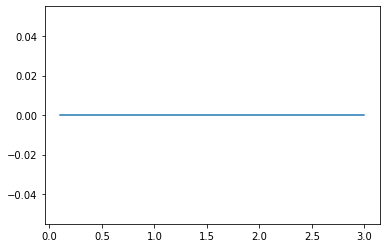

In [97]:
plt.plot(omega_cs/2/np.pi,gods)

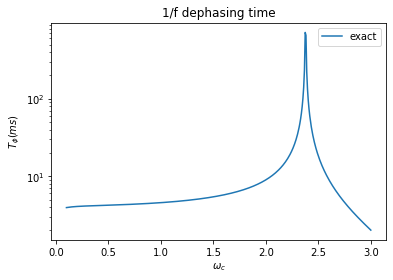

In [99]:
plt.plot(omega_cs/2/np.pi,(T1fs)/1e6,label= 'exact')
# plt.plot(omega_cs/2/np.pi,1/(gods**2)*(γ_s/1e3),label = '$(Δ/g)^2 3μs$')
plt.yscale('log')
plt.title('1/f dephasing time')
plt.ylabel('$T_\phi(ms)$')
plt.xlabel('$\omega_c$')
plt.legend()

In [234]:
(1/(gods**2)*(γ_s/1e3))[300]

0.595799837476944

In [235]:
gods[300]

0.0633544757653835